In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision
from torchvision import transforms
import os

In [2]:
base_dir = r'./datasets/4weather'
train_dir = os.path.join(base_dir , 'train')
test_dir = os.path.join(base_dir , 'test')   

In [3]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomResizedCrop(192, scale=(0.6,1.0), ratio=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0),
    torchvision.transforms.ColorJitter(brightness=0, contrast=0.5, saturation=0, hue=0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

In [4]:
test_transform = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

In [5]:
train_ds =  torchvision.datasets.ImageFolder(
        train_dir,
        transform=train_transform
    )

In [6]:
test_ds =  torchvision.datasets.ImageFolder(
        test_dir,
        transform=test_transform
    )

In [7]:
BTACH_SIZE = 32

In [8]:
train_dl = torch.utils.data.DataLoader(
                            train_ds,
                            batch_size=BTACH_SIZE,
                            shuffle=True
)

In [9]:
test_dl = torch.utils.data.DataLoader(
                            test_ds,
                            batch_size=BTACH_SIZE,
)

In [10]:
model = torchvision.models.vgg16(pretrained=True)

In [11]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
for param in model.features.parameters():
    param.requires_grad = False

In [13]:
model.classifier[-1].out_features = 4

In [14]:
#model.fc = torch.nn.Linear(model.fc.in_features, 4)

In [15]:
if torch.cuda.is_available():
    model.to('cuda')

In [16]:
loss_fn = nn.CrossEntropyLoss()

In [17]:
# Decay LR by a factor of 0.1 every 7 epochs
from torch.optim import lr_scheduler
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [18]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [19]:
epochs = 30

In [20]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.045 accuracy: 0.714 test_loss：  0.019 test_accuracy: 0.884
epoch:  1 loss：  0.018 accuracy: 0.912 test_loss：  0.01 test_accuracy: 0.951
epoch:  2 loss：  0.009 accuracy: 0.928 test_loss：  0.026 test_accuracy: 0.884
epoch:  3 loss：  0.006 accuracy: 0.959 test_loss：  0.018 test_accuracy: 0.933
epoch:  4 loss：  0.008 accuracy: 0.956 test_loss：  0.013 test_accuracy: 0.947
epoch:  5 loss：  0.014 accuracy: 0.934 test_loss：  0.014 test_accuracy: 0.951
epoch:  6 loss：  0.017 accuracy: 0.923 test_loss：  0.026 test_accuracy: 0.924
epoch:  7 loss：  0.011 accuracy: 0.961 test_loss：  0.016 test_accuracy: 0.947
epoch:  8 loss：  0.005 accuracy: 0.978 test_loss：  0.018 test_accuracy: 0.947
epoch:  9 loss：  0.004 accuracy: 0.976 test_loss：  0.014 test_accuracy: 0.938
epoch:  10 loss：  0.002 accuracy: 0.978 test_loss：  0.016 test_accuracy: 0.956
epoch:  11 loss：  0.004 accuracy: 0.977 test_loss：  0.014 test_accuracy: 0.951
epoch:  12 loss：  0.003 accuracy: 0.981 test_loss：  0.017 test_

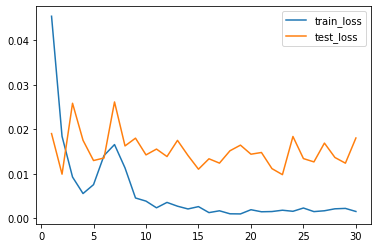

In [21]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

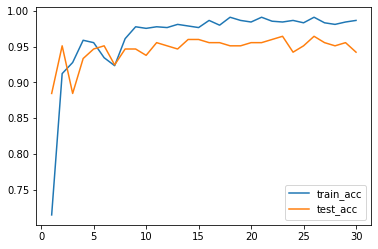

In [22]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()